# Poetry Generator

The purpose of this notebook is to explore the power of LLM and RNN models to generate poetry from using song lyrics as a dataset. The song datasets I plan to use come from a github repo that has various lyrics from many artists written in txt files.
* https://github.com/laxmimerit/poetry-data

### Resources

This has been done before. The articles are references that I used for this notebook.

* https://kgptalkie.medium.com/poetry-generation-using-tensorflow-keras-and-lstm-75c4e4b7f07e
* https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov/notebook
* https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms
* https://www.tensorflow.org/text/tutorials/text_generation

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import random
import re
import string
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-04 11:26:30.376106


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [9]:
def download_preprocess_and_structure_data(url_by_artist: typing.Dict[str, str]) -> pd.DataFrame:
    """ Downloads and structures the data into a pandas DF.

        Args:
            url_by_artist (Dict[str, str]): the url to grab data from for the corresponding artist.

        Returns:
            (DataFrame) the corresponding structured dataframe.
    """
    all_data = []
    pattern = re.compile(r'\s+')

    for artist in url_by_artist:
        sentences = data_toolbox.read_txt_file_from_url(url_by_artist[artist], delimiter='\n')

        for sentence in sentences:
            cleaned_sentence = ml_toolbox.preprocessing.language.clean_text(sentence)

            if len(cleaned_sentence) > 0:
                all_data.append({'artist': artist, 'sentence': cleaned_sentence})

    return pd.DataFrame(all_data)

In [10]:
def generate_text(seed_text: str,
                  num_words_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder) -> str:
    """ Generates a sentence from the seed text with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_words_to_create (int): how many words to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.

        Returns:
            (str) the generated text.
    """
    generated_text = seed_text

    for _ in range(num_words_to_create):
        pred_probs = model.predict([generated_text], verbose=0)
        pred_word_index = tf.argmax(pred_probs, axis=1)[0]
        pred_probs[0][pred_word_index] = 1  # Due to the size of the word list, rounding doesn't always gurantee a selected word
        pred_vector = tf.round(pred_probs)
        predicted_word = str(one_hot_encoder.inverse_transform(pred_vector)[0][0])
        generated_text += f' {predicted_word}'

    return generated_text

In [11]:
def generate_poem(seed_texts: typing.List[str],
                  num_words_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder) -> str:
    """ Generates a sentence from the seed texts with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_words_to_create (int): how many words to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.

        Returns:
            (str) the generated text.
    """
    for seed_text in seed_texts:
        print(generate_text(seed_text, num_words_to_create, model, one_hot))

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file from the links below.

* https://github.com/laxmimerit/poetry-data

For this notebook, I am going to limit my datasets to the following artists:

* [The Beatles](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt)
* [Adele](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt)
* [Bob Dylan](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt)

### Constants

In [12]:
DATA_URLS = {
    'beatles': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt',
    'adele': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt',
    'bob_dylan': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt',
}

### Downloading & Analyzing Data

In [13]:
data_df = download_preprocess_and_structure_data(DATA_URLS)
data_df

,artist,sentence
0,beatles,yesterday all my troubles seemed so far away
1,beatles,now it looks as though theyre here to stay
2,beatles,oh i believe in yesterday suddenly im not half...
3,beatles,theres a shadow hanging over me
4,beatles,oh yesterday came suddenly why she had to go i...
...,...,...
9454,bob_dylan,shine your light shine your light on me
9455,bob_dylan,shine your light shine your light on me
9456,bob_dylan,shine your light shine your light on me
9457,bob_dylan,ya know i just couldn’t make it by myself


In [14]:
sentences = data_df.sentence.to_numpy()
sentences[:5]

array(['yesterday all my troubles seemed so far away',
       'now it looks as though theyre here to stay',
       'oh i believe in yesterday suddenly im not half the man i used to be',
       'theres a shadow hanging over me',
       'oh yesterday came suddenly why she had to go i dont know she wouldnt say'],
      dtype=object)

In [15]:
sentences[-5:]

array(['shine your light shine your light on me',
       'shine your light shine your light on me',
       'shine your light shine your light on me',
       'ya know i just couldn’t make it by myself',
       'i’m a little too blind to see'], dtype=object)

In [16]:
# Seeing the vocab
word_counts = ml_toolbox.analysis.language.get_word_counts(sentences)

len(word_counts)

5683

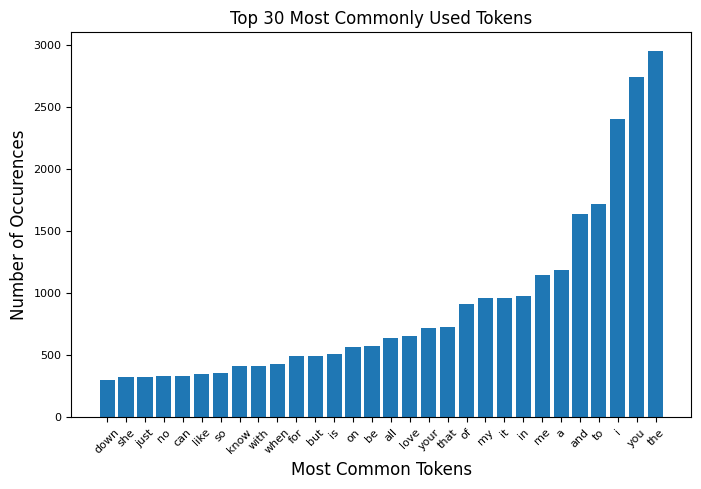

In [17]:
ml_toolbox.analysis.language.plot_token_counts(word_counts, most_common=True, n=30)

In [18]:
# Seeing the Characters
character_counts = ml_toolbox.analysis.language.get_character_counts(sentences)

len(character_counts)

41

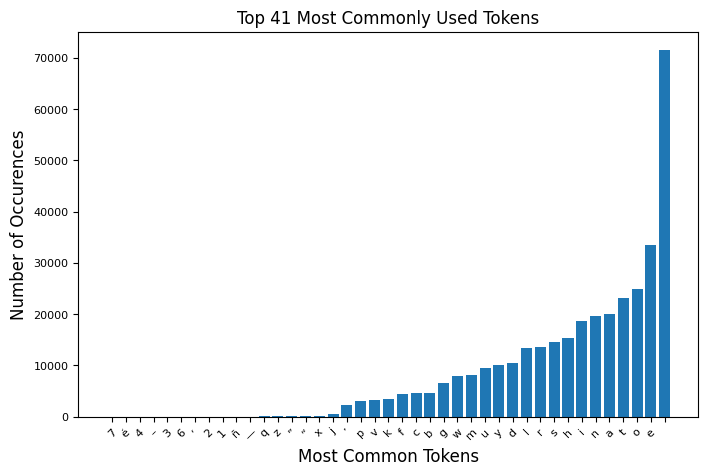

In [19]:
ml_toolbox.analysis.language.plot_token_counts(character_counts, most_common=True, n=41)

### Creating Training Data

In [20]:
X, y = ml_toolbox.preprocessing.language.create_sequenced_data_labels_from_sentences(sentences)
X[:3], y[:3]

(['yesterday', 'yesterday all', 'yesterday all my'], ['all', 'my', 'troubles'])

In [21]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(np.array(list(word_counts)).reshape((-1,1)))

y_one_hot_encoded = one_hot_encoder.transform(np.array(y).reshape((-1,1)))

y_one_hot_encoded.shape

(62035, 5683)

### Creating Datasets

In [22]:
train_dataset = data_toolbox.datasets.generate_dataset_from_data([X], y_one_hot_encoded)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 5683), dtype=tf.float64, name=None))>

## Experiments

I am going to run a handful of experiments to try and generate poems, as listed below:

* Experiment-0 (Baseline): LSTM w/ Token Embeddings
* Experiment-1: Universal Sentence Encoder w/ Token Embeddings
* Experiment-2: Conv1D w/ Token Embeddings
* Experiment-3: Bidirectional LSTM w/ Token Embeddings
* Experiment-4: LSTM w/ Character Embeddings
* Experiment-5: LSTM w/ Token Embeddings + Character Embeddings
* Experiment-6: Bidirectional LSTM w/ Token Embeddings + Character Embeddings

### Constants

In [23]:
TOTAL_WORDS = len(word_counts)
TOTAL_CHARS = len(character_counts)

UNIVERSAL_SENTENCE_ENCODER_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

TEST_SEED_TEXTS = [
    'Love is true',
    'Tomorrow comes',
    'Yesterday we',
    'But today',
]

### Preprocessing Layer Setup

Many embedding layers will be reused for more than one of the experiments mentioned above. These steps will setup the layers to be used in experiments such that they can be reused for multiple models. The various layers to be made are:

* `text_vectorizer` (TextVectorizer)
* `token_embedding` (Embedding)
* `character_vectorizer` (TextVectorizer)
* `character_embeddings` (Embedding)

#### Token Embeddings

In [24]:
# Find average number of tokens
sent_lens = [len(sentence.split()) for sentence in sentences]
round(sum(sent_lens) / len(sentences))

8

In [25]:
max(sent_lens)

34

In [26]:
# How long of a sentence covers 98% of the examples?
int(np.percentile(sent_lens, 98))

16

In [27]:
# Setup text vectorization params
max_vocab_length = 10000  # Max words to have in our vocab
max_length = 16

In [28]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

# Adapt the vectorizer to the training data
text_vectorizer.adapt(sentences)

In [29]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]

len(words_in_vocab), top_5_words, least_common_5_words

(5685,
 ['', '[UNK]', 'the', 'you', 'i'],
 ['abel', 'abeatin’', 'abandon', 'aaaaahhhhhhhhhh', '61”'])

In [30]:
# Setting up the Embedding layer
token_embedding = tf.keras.layers.Embedding(input_dim=len(words_in_vocab),
                                            output_dim=128,  # GPU's work well when number is divisible by 8
                                            mask_zero=True,
                                            name='token_embedding')
token_embedding

In [31]:
# Testing out an example sentence
target_sentence = random.choice(sentences)

# Looking at the steps of tokenization
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 all together now
Sentence after vectorization: 
 [[ 16 136  45   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Sentence after embedding: 
 [[[ 0.01009097  0.03698505  0.0361964  ... -0.04769064 -0.01288216
    0.0036797 ]
  [-0.02136162  0.0080164   0.03916038 ... -0.04010109 -0.04956752
   -0.02316355]
  [-0.00475581 -0.00983312 -0.00997546 ... -0.01963949  0.01505829
    0.02240748]
  ...
  [-0.03168239  0.00091019 -0.03967668 ...  0.02529931  0.03853485
   -0.01562084]
  [-0.03168239  0.00091019 -0.03967668 ...  0.02529931  0.03853485
   -0.01562084]
  [-0.03168239  0.00091019 -0.03967668 ...  0.02529931  0.03853485
   -0.01562084]]]
Embedded sentence shape: (1, 16, 128)


#### Character Embeddings

In [32]:
# Find average number of tokens
char_lens = [len(sentence) for sentence in sentences]
round(sum(char_lens) / len(sentences))

36

In [33]:
max(char_lens)

150

In [34]:
# How long of a sentence covers 98% of the examples?
output_sequence_len = int(np.percentile(char_lens, 98))
output_sequence_len

76

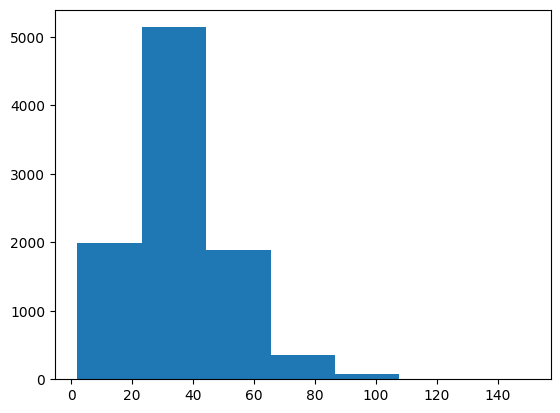

In [35]:
plt.hist(char_lens, bins=7);

In [36]:
# Figuring out the total alpha-numeric characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token ([UNK])
NUM_CHAR_TOKENS

70

In [38]:
# Setting up a text vectorization layer (tokenization)
character_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_len,
    split='character',
    name='char_vectorizer')

# Adapt the vectorizer to the training data
character_vectorizer.adapt(X)

In [39]:
char_vocab = character_vectorizer.get_vocabulary()
print(f'Number of Different Characters: {len(char_vocab)}')
print(f'5 Most Common Characters: {char_vocab[:5]}')
print(f'5 Least Common Characters: {char_vocab[-5:]}')

Number of Different Characters: 42
5 Most Common Characters: ['', '[UNK]', ' ', 'e', 't']
5 Least Common Characters: ['2', '3', '7', '4', 'é']


In [40]:
character_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                output_dim=25,
                                                mask_zero=True,
                                                name='character_embedding')
character_embedding

In [41]:
# Testing out an example sentence
target_chars = random.choice(X)

# Looking at the steps of tokenization
print(f'Chars before vectorization: \n {target_chars}')

vectorized_chars = character_vectorizer([target_chars])
print(f'Chars after vectorization: \n {vectorized_chars}')
embedded_chars = character_embedding(vectorized_chars)
print(f'Chars after embedding: \n {embedded_chars}')
print(f'Embedded chars shape: {embedded_chars.shape}')

Chars before vectorization: 
 i wont go i cant do
Chars after vectorization: 
 [[ 7  2 16  5  8  4  2 18  5  2  7  2 20  6  8  4  2 14  5  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
Chars after embedding: 
 [[[ 0.00451929  0.01363409 -0.03261564 ... -0.01050571  0.01482653
    0.00516421]
  [ 0.0332782  -0.02296648 -0.01791266 ...  0.00143404 -0.01140386
    0.04522279]
  [-0.04798914  0.00488643  0.04727607 ...  0.01553125  0.03740877
    0.03616777]
  ...
  [-0.04934384 -0.02037593  0.00794519 ...  0.0006755  -0.0304862
    0.0189703 ]
  [-0.04934384 -0.02037593  0.00794519 ...  0.0006755  -0.0304862
    0.0189703 ]
  [-0.04934384 -0.02037593  0.00794519 ...  0.0006755  -0.0304862
    0.0189703 ]]]
Embedded chars shape: (1, 76, 25)


### Experiment-0 (Baseline): LSTM with Token Embeddings

For a baseline, going to use a very simple model with only a single LSTM layer.

In [42]:
# Constants
model_0_name = 'model_0_simple_lstm'

In [43]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)
model_0.summary()

Model: "model_0_simple_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5683)              369395    
                                                                 
Total params: 1146483 (4.37 MB)
Trainable param

In [44]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [45]:
model_0.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 23s 11ms/step - loss: 6.6949 - accuracy: 0.0468
Epoch 2/10
1939/1939 [==============================] - 22s 11ms/step - loss: 6.0172 - accuracy: 0.0644
Epoch 3/10
1939/1939 [==============================] - 23s 12ms/step - loss: 5.5929 - accuracy: 0.0910
Epoch 4/10
1939/1939 [==============================] - 23s 12ms/step - loss: 5.2560 - accuracy: 0.1140
Epoch 5/10
1939/1939 [==============================] - 22s 11ms/step - loss: 4.9512 - accuracy: 0.1381
Epoch 6/10
1939/1939 [==============================] - 22s 11ms/step - loss: 4.6694 - accuracy: 0.1655
Epoch 7/10
1939/1939 [==============================] - 22s 11ms/step - loss: 4.4111 - accuracy: 0.1927
Epoch 8/10
1939/1939 [==============================] - 22s 11ms/step - loss: 4.1725 - accuracy: 0.2209
Epoch 9/10
1939/1939 [==============================] - 22s 12ms/step - loss: 3.9618 - accuracy: 0.2505
Epoch 10/10
1939/1939 [==============================] - 22s 11m

In [46]:
generate_poem(TEST_SEED_TEXTS, 8, model_0, one_hot_encoder)

Love is true love you love me i need a shot
Tomorrow comes on the road with the light of the
Yesterday we could wake up when you gonna be a
But today that he was a million miles from you


### Experiment-1: Universal Sentence Encoder with Token Embeddings

In [47]:
# Constants
model_1_name = 'model_1_use'

In [48]:
# Build Model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(UNIVERSAL_SENTENCE_ENCODER_URL,
                                      trainable=False,
                                      name='USE')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

INFO:absl:Using /var/folders/sj/rsg548nx63dc931tmwt4nnq80000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_1_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5683)              733107    
                                                                 
Total params: 257596595 (982.65 MB)
Trainable params: 798771 (3.05 MB)
Non-trainable params: 256797824 (979.61 MB)
_______________________________________

In [49]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [50]:
model_1.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 9s 4ms/step - loss: 6.6350 - accuracy: 0.0529
Epoch 2/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.9788 - accuracy: 0.0668
Epoch 3/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.6265 - accuracy: 0.0776
Epoch 4/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.2583 - accuracy: 0.0933
Epoch 5/10
1939/1939 [==============================] - 8s 4ms/step - loss: 4.8754 - accuracy: 0.1119
Epoch 6/10
1939/1939 [==============================] - 8s 4ms/step - loss: 4.4922 - accuracy: 0.1417
Epoch 7/10
1939/1939 [==============================] - 8s 4ms/step - loss: 4.1476 - accuracy: 0.1743
Epoch 8/10
1939/1939 [==============================] - 9s 5ms/step - loss: 3.8586 - accuracy: 0.2074
Epoch 9/10
1939/1939 [==============================] - 9s 5ms/step - loss: 3.6261 - accuracy: 0.2444
Epoch 10/10
1939/1939 [==============================] - 9s 5ms/step - loss: 3.440

In [51]:
generate_poem(TEST_SEED_TEXTS, 8, model_1, one_hot_encoder)

Love is true you you you can feel like like you
Tomorrow comes you you ready ready to ready to ready
Yesterday we there to to to you to were so
But today my heart is i’m i’m so i’m so


### Experiment-2: Conv1D with Token Embeddings

In [52]:
# Constants
model_2_name = 'model_2_conv1d_token'

In [53]:
# Build Model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)
model_2.summary()

Model: "model_2_conv1d_token"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                              

In [54]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [55]:
model_2.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 11s 6ms/step - loss: 6.3549 - accuracy: 0.0787
Epoch 2/10
1939/1939 [==============================] - 11s 6ms/step - loss: 5.4048 - accuracy: 0.1295
Epoch 3/10
1939/1939 [==============================] - 10s 5ms/step - loss: 4.8972 - accuracy: 0.1629
Epoch 4/10
1939/1939 [==============================] - 10s 5ms/step - loss: 4.4852 - accuracy: 0.1966
Epoch 5/10
1939/1939 [==============================] - 10s 5ms/step - loss: 4.1238 - accuracy: 0.2301
Epoch 6/10
1939/1939 [==============================] - 10s 5ms/step - loss: 3.7643 - accuracy: 0.2713
Epoch 7/10
1939/1939 [==============================] - 10s 5ms/step - loss: 3.4548 - accuracy: 0.3082
Epoch 8/10
1939/1939 [==============================] - 11s 6ms/step - loss: 3.1883 - accuracy: 0.3444
Epoch 9/10
1939/1939 [==============================] - 10s 5ms/step - loss: 2.9595 - accuracy: 0.3770
Epoch 10/10
1939/1939 [==============================] - 11s 5ms/step - l

In [56]:
generate_poem(TEST_SEED_TEXTS, 8, model_2, one_hot_encoder)

Love is true love you do you do me no more
Tomorrow comes of the streets child of clay people joey
Yesterday we was gone to the way of your bride’s
But today did not the streets child of clay people


### Experiment-3: Bidirectional LSTM with Token Embeddings

In [57]:
# Constants
model_3_name = 'model_3_bidirectional_lstm'

In [58]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)
model_3.summary()

Model: "model_3_bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 5683)              733107    
                                        

In [59]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [60]:
model_3.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 26s 12ms/step - loss: 6.1453 - accuracy: 0.0871
Epoch 2/10
1939/1939 [==============================] - 22s 11ms/step - loss: 5.0676 - accuracy: 0.1493
Epoch 3/10
1939/1939 [==============================] - 22s 11ms/step - loss: 4.4389 - accuracy: 0.2065
Epoch 4/10
1939/1939 [==============================] - 23s 12ms/step - loss: 3.9381 - accuracy: 0.2585
Epoch 5/10
1939/1939 [==============================] - 23s 12ms/step - loss: 3.5251 - accuracy: 0.3124
Epoch 6/10
1939/1939 [==============================] - 23s 12ms/step - loss: 3.1748 - accuracy: 0.3661
Epoch 7/10
1939/1939 [==============================] - 24s 12ms/step - loss: 2.8840 - accuracy: 0.4145
Epoch 8/10
1939/1939 [==============================] - 24s 12ms/step - loss: 2.6324 - accuracy: 0.4576
Epoch 9/10
1939/1939 [==============================] - 24s 12ms/step - loss: 2.4247 - accuracy: 0.4942
Epoch 10/10
1939/1939 [==============================] - 24s 12m

In [61]:
generate_poem(TEST_SEED_TEXTS, 8, model_3, one_hot_encoder)

Love is true love love love love love love love love
Tomorrow comes and the judge is bulletproof to be swift
Yesterday we can bring it all the way of it
But today has been so strong to me to me


### Experiment-4: LSTM with Character Embeddings

In [62]:
# Constants
model_4_name = 'model_4_lstm_char'

In [63]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)
model_4.summary()

Model: "model_4_lstm_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 76)                0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 76, 25)            1050      
 ding)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 64)                23040     
                                                                 
 dense_5 (Dense)             (None, 5683)              369395    
                                                                 
Total params: 393485 (1.50 MB)
Trainable params: 

In [64]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [65]:
model_4.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 40s 20ms/step - loss: 6.7054 - accuracy: 0.0457
Epoch 2/10
1939/1939 [==============================] - 38s 20ms/step - loss: 6.3469 - accuracy: 0.0473
Epoch 3/10
1939/1939 [==============================] - 38s 20ms/step - loss: 6.2166 - accuracy: 0.0494
Epoch 4/10
1939/1939 [==============================] - 39s 20ms/step - loss: 6.0378 - accuracy: 0.0550
Epoch 5/10
1939/1939 [==============================] - 38s 20ms/step - loss: 5.8356 - accuracy: 0.0616
Epoch 6/10
1939/1939 [==============================] - 38s 20ms/step - loss: 5.6282 - accuracy: 0.0676
Epoch 7/10
1939/1939 [==============================] - 38s 20ms/step - loss: 5.4373 - accuracy: 0.0744
Epoch 8/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.2713 - accuracy: 0.0810
Epoch 9/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.1240 - accuracy: 0.0879
Epoch 10/10
1939/1939 [==============================] - 39s 20m

In [66]:
generate_poem(TEST_SEED_TEXTS, 8, model_4, one_hot_encoder)

Love is true to be the sun a million the sun
Tomorrow comes and the streets of the streets of the
Yesterday we all the streets of the streets of the
But today you can i need a shot of the


### Experiment-5: LSTM with Character Embeddings & Token Embeddings

In [67]:
# Constants
model_5_name = 'model_5_lstm_char_token'

In [68]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Token Embedding
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
token_lstm = tf.keras.layers.LSTM(64)(x)

token_model = tf.keras.models.Model(inputs, token_lstm, name=model_5_name)

# Character Embedding
x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
char_lstm = tf.keras.layers.LSTM(64)(x)

character_model = tf.keras.models.Model(inputs, char_lstm, name=model_5_name)

# Concatenating outputs
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, character_model.output])

# Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(final_dropout)

model_5 = tf.keras.models.Model(inputs=inputs,
                                outputs=outputs,
                                name=model_5_name)
model_5.summary()

Model: "model_5_lstm_char_token"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 16)                   0         ['input_6[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 76)                   0         ['input_6[0][0]']             
 rization)                                                                                        
                                                                            

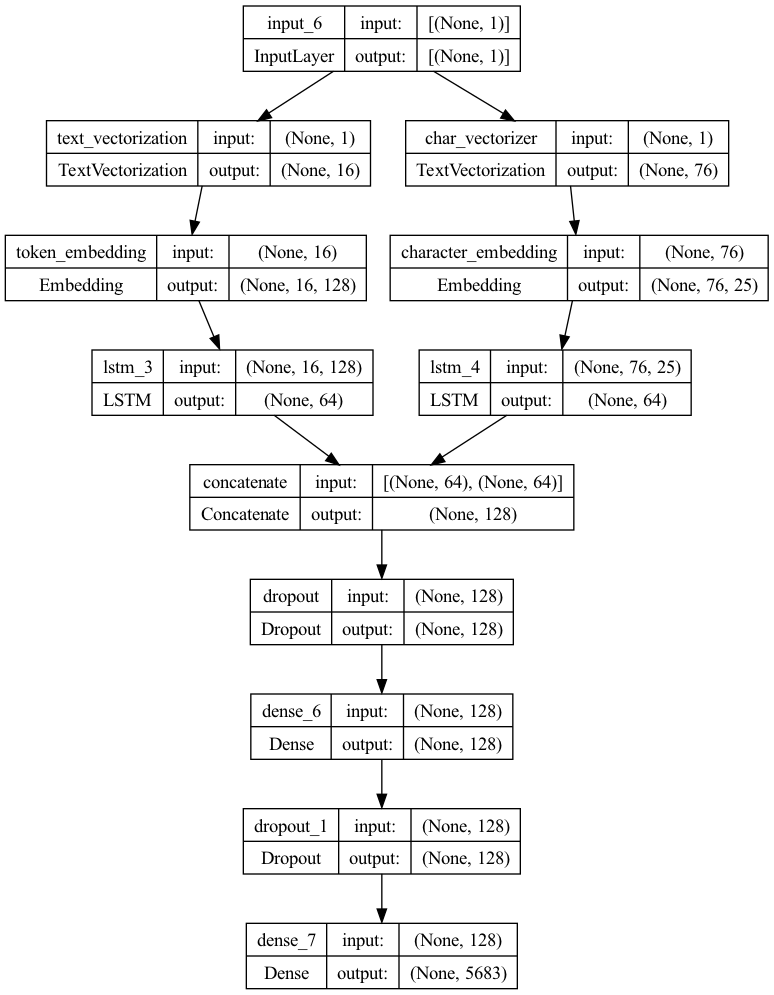

In [69]:
ml_toolbox.analysis.model.plot_model(model_5)

In [70]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [71]:
model_5.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 45s 22ms/step - loss: 6.4019 - accuracy: 0.0693
Epoch 2/10
1939/1939 [==============================] - 41s 21ms/step - loss: 5.7395 - accuracy: 0.1056
Epoch 3/10
1939/1939 [==============================] - 42s 21ms/step - loss: 5.4862 - accuracy: 0.1206
Epoch 4/10
1939/1939 [==============================] - 42s 22ms/step - loss: 5.2942 - accuracy: 0.1350
Epoch 5/10
1939/1939 [==============================] - 42s 22ms/step - loss: 5.1450 - accuracy: 0.1441
Epoch 6/10
1939/1939 [==============================] - 42s 21ms/step - loss: 5.0155 - accuracy: 0.1501
Epoch 7/10
1939/1939 [==============================] - 42s 22ms/step - loss: 4.9114 - accuracy: 0.1569
Epoch 8/10
1939/1939 [==============================] - 42s 22ms/step - loss: 4.8209 - accuracy: 0.1632
Epoch 9/10
1939/1939 [==============================] - 42s 21ms/step - loss: 4.7496 - accuracy: 0.1678
Epoch 10/10
1939/1939 [==============================] - 41s 21m

In [72]:
generate_poem(TEST_SEED_TEXTS, 8, model_5, one_hot_encoder)

Love is true love is a way to be the road
Tomorrow comes the world is a way to be the
Yesterday we got a way to be the road is
But today can be the road is a road to


### Experiment-6: Bidirectional LSTM w/ Character Embeddings & Token Embeddings

In [73]:
# Constants
model_6_name = 'model_5_bidirectional_lstm_char_token'

In [74]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Token Embedding
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
token_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

token_model = tf.keras.models.Model(inputs, token_lstm, name=model_5_name)

# Character Embedding
x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
char_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

character_model = tf.keras.models.Model(inputs, char_lstm, name=model_5_name)

# Concatenating outputs
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, character_model.output])

# Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(final_dropout)

model_6 = tf.keras.models.Model(inputs=inputs,
                                outputs=outputs,
                                name=model_6_name)
model_6.summary()

Model: "model_5_bidirectional_lstm_char_token"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 16)                   0         ['input_7[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 76)                   0         ['input_7[0][0]']             
 rization)                                                                                        
                                                              

In [75]:
model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [76]:
model_6.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 50s 23ms/step - loss: 6.3495 - accuracy: 0.0706
Epoch 2/10
1939/1939 [==============================] - 44s 23ms/step - loss: 5.6262 - accuracy: 0.1155
Epoch 3/10
1939/1939 [==============================] - 44s 23ms/step - loss: 5.3295 - accuracy: 0.1375
Epoch 4/10
1939/1939 [==============================] - 44s 23ms/step - loss: 5.1319 - accuracy: 0.1518
Epoch 5/10
1939/1939 [==============================] - 44s 22ms/step - loss: 4.9727 - accuracy: 0.1616
Epoch 6/10
1939/1939 [==============================] - 44s 23ms/step - loss: 4.8520 - accuracy: 0.1688
Epoch 7/10
1939/1939 [==============================] - 44s 22ms/step - loss: 4.7402 - accuracy: 0.1754
Epoch 8/10
1939/1939 [==============================] - 44s 23ms/step - loss: 4.6469 - accuracy: 0.1824
Epoch 9/10
1939/1939 [==============================] - 45s 23ms/step - loss: 4.5734 - accuracy: 0.1905
Epoch 10/10
1939/1939 [==============================] - 45s 23m

In [77]:
generate_poem(TEST_SEED_TEXTS, 8, model_5, one_hot_encoder)

Love is true love to be the road of the road
Tomorrow comes the world is a way to be the
Yesterday we got a way to be the road of
But today is a moon was a way to be
